In [1]:
# Project 1 from CARND at Udacity
# Feb.22 2017

# Project introduction:
# Detect and show two lanes from video.

In [2]:
# Import
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg
from moviepy.editor import *
import numpy as np
from scipy import stats
import cv2
from itertools import combinations
from itertools import chain
from IPython.display import clear_output
%matplotlib inline

# load helper funcs
import math

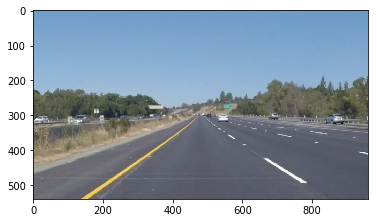

In [3]:
# some macros
video_file = 'challenge.mp4'
image_file = './solidYellowLeft.jpg'

clip = VideoFileClip(video_file)
# ipython_display(clip, width=240)

image = cv2.cvtColor(cv2.imread(image_file),cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [4]:
# Load some helper functions

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()


#     return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, np.array(vertices, dtype=np.int32), ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for seg in line:
            # print('This line is: ', seg)
            cv2.line(img, (seg[0], seg[1]), (seg[2], seg[3]), color, thickness)


def draw_line(img, line, color=[255, 0, 0], thickness=2):
    """
    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for seg in line:
        cv2.line(img, (seg[0], seg[1]), (seg[2], seg[3]), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1.0, λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


def _find_slope(_seg):
    """
    Find slope of input segment
    :param _seg: [x1 y1 x2 y2] can be in list or in np.array
    :return: slope in float
    """
    return (_seg[1]-_seg[3])/(_seg[0]-_seg[2])


def _find_line(_segs):
    """
    Accept bunch of segments and use linear regression to calculate an explicit line
    :param _segs:
    :return:
    """
    if len(_segs.shape)<2 or _segs.shape[1] != 4:
        return 0.000001, 0
    points_x = _segs[:, 0:3:2]
    points_x = np.resize(points_x,(1, points_x.size))
    points_y = _segs[:, 1:4:2]
    points_y = np.resize(points_y,(1,points_y.size))
    _slope, _intercept, r_value, p_value, std_err = stats.linregress(*points_x,*points_y)
    return _slope, _intercept


def _generate_line(_slope, _intercept, img, y_fragment=0.64):
    """
        generate line from parameter (k,b) via y=kx+b
        the boundary is set by 64% bottom to top
    """
    upper_y = int(img.shape[0]*y_fragment)
    lower_y = img.shape[0]-1
    upper_x = int((upper_y-_intercept)/_slope)
    lower_x = int((lower_y-_intercept)/_slope)
    return lower_x, lower_y, upper_x, upper_y


def color_mask(image, mode, lower, upper):
    """
        color_mask can be used in two mode: hsv and rgb
    """
    if mode == 'hsv':
        # Convert BGR to HSV
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        # Threshold the HSV image to get only blue colors
        mask = cv2.inRange(hsv, np.array(lower,np.uint8), np.array(upper,np.uint8))
    else:
        mask = cv2.inRange(image, np.array(lower,np.uint8), np.array(upper,np.uint8))
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(image, image, mask=mask)
    return res, mask

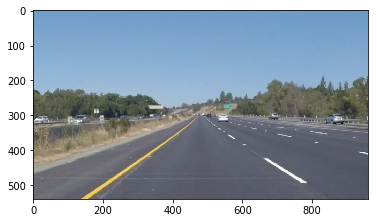

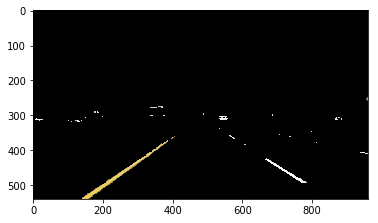

In [5]:
# Recall the pipline: raw_image ->  select color -> grayscale, smooth, Canny ->
# 1st pass Hough transform -> 2nd pass Hough transform -> find explicit two lanes ->
# draw lanes

# Now is *color selecting*
final_color_yellow, mask_yellow = color_mask(image, 'hsv', (90, 100, 100), (120, 255, 255))
final_color_white, mask_white = color_mask(image, 'bgr', (200, 200, 200), (255, 255, 255))

final_color = cv2.bitwise_or(cv2.bitwise_and(image, final_color_yellow), cv2.bitwise_and(image, final_color_white))

plt.figure()
plt.imshow(image)
plt.figure()
plt.imshow(final_color)

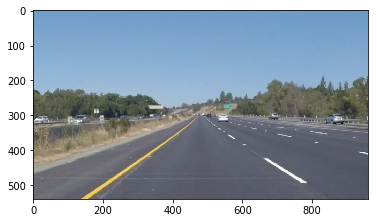

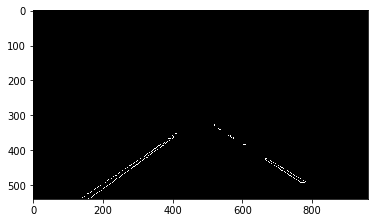

In [6]:
# Now is *grayscale, smooth, Canny*
gray_image = grayscale(final_color)
smooth_image = gaussian_blur(gray_image, 3)

# Define our parameters for Canny and apply
low_threshold = 1
high_threshold = 150
edges = cv2.Canny(smooth_image, low_threshold, high_threshold)
mask = np.zeros_like(edges)
ignore_mask_color = 255

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0, imshape[0]), (int(imshape[1]*2/5), int(imshape[0]*6/10)),
                      (int(imshape[1]*3/5), int(imshape[0]*6/10)), (imshape[1], imshape[0])]],
                    dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

plt.figure()
plt.imshow(image)
plt.figure()
plt.imshow(masked_edges,cmap='gray')

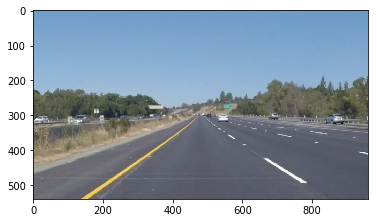

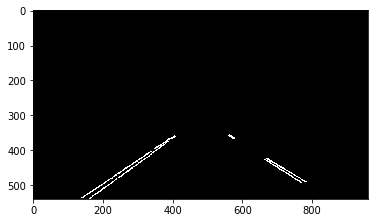

In [7]:
# Now is *1st pass of Hough transform*
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 10  # minimum number of votes (intersections in Hough grid cell)
min_line_len = 5  # minimum number of pixels making up a line
max_line_gap = 2  # maximum gap in pixels between connectable line segments
line_image = np.copy(image) * 0  # creating a blank to draw lines on
hough_image, first_hough = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
hough_image = cv2.cvtColor(hough_image, cv2.COLOR_RGB2GRAY)

plt.figure()
plt.imshow(image)
plt.figure()
plt.imshow(hough_image,cmap='gray')

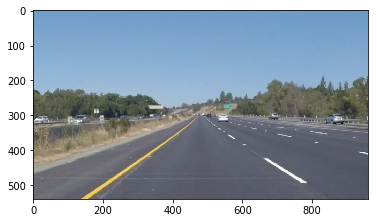

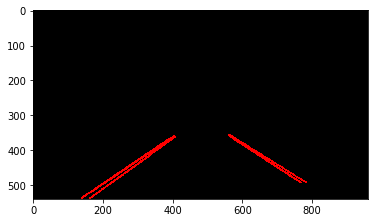

In [8]:
# Now is *2nd pass of Hough transform*
# second pass
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 360  # angular resolution in radians of the Hough grid
threshold = 50  # minimum number of votes (intersections in Hough grid cell)
min_line_len = 50  # minimum number of pixels making up a line
max_line_gap = 150  # maximum gap in pixels between connectable line segments

hough_image_2, second_hough = hough_lines(hough_image, rho, theta, threshold, min_line_len, max_line_gap)

plt.figure()
plt.imshow(image)
plt.figure()
plt.imshow(hough_image_2,cmap='gray')

In [9]:
# Find left and right lane
segs = (np.concatenate(second_hough[:]))   #extract segments from segs
seg_left = []
seg_right = []
for seg in segs:
    if abs(_find_slope(seg) + 0.5) < 0.3:    #find segs belonging to left lane
        seg_left.append(seg)
    elif abs(_find_slope(seg) - 0.5) < 0.3:   #find segs belonging to right lane
        seg_right.append(seg)
seg_left = np.array(seg_left)
seg_right = np.array(seg_right)

In [10]:
# Draw left and right lane on a blank canvas
blank = np.zeros_like(image)
draw_line(blank, [_generate_line(*_find_line(seg_left), image),
                  _generate_line(*_find_line(seg_right), image)], thickness=10)

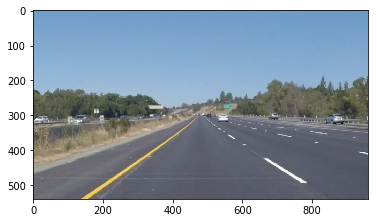

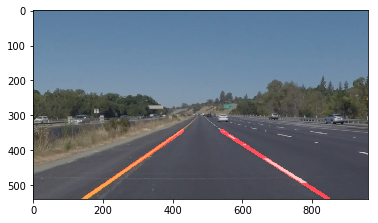

In [11]:
final = weighted_img(blank, image)

plt.figure()
plt.imshow(image)
plt.figure()
plt.imshow(final)

In [12]:
# Lane detection on picture ended.
# Move on to Lane detection on video.

In [13]:
# So we pack the pipline in a function called lane_detect(image):
def process_image(image):
    """
        Lane detection on a static image. This image should be
        in RGB format.
        If the image is imported from cv2.imshow, 
        should pass image to 
        cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    """
    # STEP1: color selection
    final_color_yellow, mask_yellow = color_mask(image, 'hsv', (90, 100, 100), (120, 255, 255))
    final_color_white, mask_white = color_mask(image, 'bgr', (200, 200, 200), (255, 255, 255))
    final_color = cv2.bitwise_or(cv2.bitwise_and(image, final_color_yellow), cv2.bitwise_and(image, final_color_white))

    # STEP2: grayscale, smooth, Canny
    gray_image = grayscale(final_color)
    smooth_image = gaussian_blur(gray_image, 3)

    # Define our parameters for Canny and apply
    low_threshold = 1
    high_threshold = 150
    edges = cv2.Canny(smooth_image, low_threshold, high_threshold)
    mask = np.zeros_like(edges)
    ignore_mask_color = 255

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(0, imshape[0]), (int(imshape[1]*2/5), int(imshape[0]*6/10)),
                          (int(imshape[1]*3/5), int(imshape[0]*6/10)), (imshape[1], imshape[0])]],
                        dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    # STEP3: 1ST pass Hough transform
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 10  # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 5  # minimum number of pixels making up a line
    max_line_gap = 2  # maximum gap in pixels between connectable line segments
    line_image = np.copy(image) * 0  # creating a blank to draw lines on
    hough_image, first_hough = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    hough_image = cv2.cvtColor(hough_image, cv2.COLOR_RGB2GRAY)

    # STEP4: 2ND pass Hough transform
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 360  # angular resolution in radians of the Hough grid
    threshold = 50  # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 50  # minimum number of pixels making up a line
    max_line_gap = 150  # maximum gap in pixels between connectable line segments

    hough_image_2, second_hough = hough_lines(hough_image, rho, theta, threshold, min_line_len, max_line_gap)

    # STEP5: Find left and right lane
    segs = (np.concatenate(second_hough[:]))
    seg_left = []
    seg_right = []
    for seg in segs:
        if abs(_find_slope(seg) + 0.5) < 0.3:
            seg_left.append(seg)
        elif abs(_find_slope(seg) - 0.5) < 0.3:
            seg_right.append(seg)
    seg_left = np.array(seg_left)
    seg_right = np.array(seg_right)

    # STEP6: Draw left and right lane
    blank = np.zeros_like(image)
    draw_line(blank, [_generate_line(*_find_line(seg_left), image),
                      _generate_line(*_find_line(seg_right), image)], thickness=10)

    return weighted_img(blank, image)

In [14]:
#Test with solidWhiteRight
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:09<00:00, 25.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 7.76 s, sys: 1.42 s, total: 9.18 s
Wall time: 9.93 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [16]:
# test with solidYellowLeft
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:30<00:00, 22.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 24.2 s, sys: 3.83 s, total: 28.1 s
Wall time: 31.6 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [18]:
# Test with optional challenge
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:23<00:00, 10.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 15.3 s, sys: 3.41 s, total: 18.7 s
Wall time: 25.1 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))